# Загрузка данных:

In [11]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Библиотеки

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# загружаем библиотеки 
import pandas as pd
import squarify
import matplotlib.pyplot as plt
import requests
import numpy as np
data_for_generation = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/MCH/github_/data_MCH.csv')

# Генерация данных:

 Сгенерируем данные и оценим RFM, которые помогут нам проанализировать исторические данные маркетинговых кампаний.  

 Модель RFM предназначена для сегментации пользователей на основе трех параметров: 
1.   **recency** (как давно клиент использовал продукт); 
2.   **frequency** (как часто клиент пользуется продуктом); 
3.   **monetary** (сколько денег принес клиент бизнесу/какой денежный оборот и пользователя).

Мы ранжируем эти параметры относительно общего распределения всех данных и сегменируем по заранее заданным сегментам: **ABOUT TO SLEEP, RECENT CUSTOMER, CANNOT LOOSE THEM, CHAMPION, LOST CUSTOMER, LOYAL, POTENTIAL LOYALIST, AVERAGE**.

(Для оценки RFM нам понадобилось добавить один столбец в виде денежного оборота у клиента на карте в изначальную таблицу транзакций).

Таким образом, мы можем как протестировать рекламную кампанию на похожем сегменте пользователей, так и понимать, какой сегмент пользователей из разных каналов к нам приходит. Например, много средних, не очень активных пользователей или не так много золотых.

Добавляем следующие признаки

*   Затраты пользователей



In [6]:
data_rfm = pd.DataFrame(columns=[['id', 'date', 'purchase']])

In [7]:
data_for_generation['id'] = data_for_generation['client_id']
data_for_generation['purchase'] = abs(np.random.normal(loc=data_for_generation['purchase_sum'].mean(), 
                                            scale=data_for_generation['purchase_sum'].std(), 
                                            size=data_for_generation['purchase_sum'].shape[0]))

data_for_generation['date'] = pd.date_range(start="2018-09-09",end="2022-02-02", periods = data_for_generation['purchase'].shape[0]).to_pydatetime().tolist()

In [8]:
from datetime import datetime
data_rfm_final = pd.DataFrame(index = data_for_generation.groupby(by = 'client_id').count()['purchase'].index , 
                              columns = ['purchase'],
                              data= data_for_generation.groupby(by = 'client_id').count()['purchase'])
data_rfm_final['recency'] = data_for_generation.groupby(by = 'client_id').max()['date']
data_rfm_final['monetary_mean'] = data_for_generation.groupby(by = 'client_id').mean()['purchase']
data_rfm_final['monetary_sum'] = data_for_generation.groupby(by = 'client_id').sum()['purchase']

data_rfm_final.rename(columns = {'purchase':'frequency',}, inplace = True)
data_rfm_final['recency'] = data_rfm_final['recency'].apply(lambda x: (datetime.today() - x).days)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  """


In [16]:
data_rfm_final['frequency_score'] = pd.qcut(data_rfm_final['frequency'], 3, labels=[1, 2, 3]) 
data_rfm_final['recency_score'] = pd.qcut(data_rfm_final['recency'], 3, labels=[3, 2, 1]) 
data_rfm_final['monetary_score'] = pd.qcut(data_rfm_final['monetary_sum'], 3, labels=[1, 2, 3]) 

data_rfm_final['rfm_score'] = data_rfm_final['recency_score'].astype('str') + data_rfm_final['frequency_score'].astype('str') + data_rfm_final['monetary_score'].astype('str')

rfm_score_dict = {"112":"ABOUT TO SLEEP", 
                      "113":"ABOUT TO SLEEP", 
                      "121":"ABOUT TO SLEEP",  
                      "122":"ABOUT TO SLEEP",  
                      "131":"ABOUT TO SLEEP", 
                      "211":"ABOUT TO SLEEP", 
                      "212":"ABOUT TO SLEEP", 
                      "221":"ABOUT TO SLEEP", 
                      "311":"RECENT CUSTOMER", 
                      "312":"RECENT CUSTOMER", 
                      "313":"RECENT CUSTOMER", 
                      "123":"CANNOT LOOSE THEM", 
                      "132":"CANNOT LOOSE THEM", 
                      "133":"CANNOT LOOSE THEM", 
                      "333":"CHAMPION", 
                      "111":"LOST CUSTOMER",
                      "233":"LOYAL",
                      "323":"LOYAL",
                      "332":"LOYAL",
                      "223":"POTENTIAL LOYALIST",
                      "232":"POTENTIAL LOYALIST",
                      "322":"POTENTIAL LOYALIST",
                      "331":"POTENTIAL LOYALIST",
                      "213":"AVERAGE",
                      "222":"AVERAGE",
                      "231":"AVERAGE",
                      "321":"AVERAGE"}


data_rfm_final['rfm_score_name'] = data_rfm_final['rfm_score'].apply(lambda x: rfm_score_dict[x])

In [17]:
data_rfm_final.to_csv('/content/drive/MyDrive/Colab Notebooks/MCH/data_rfm.csv')

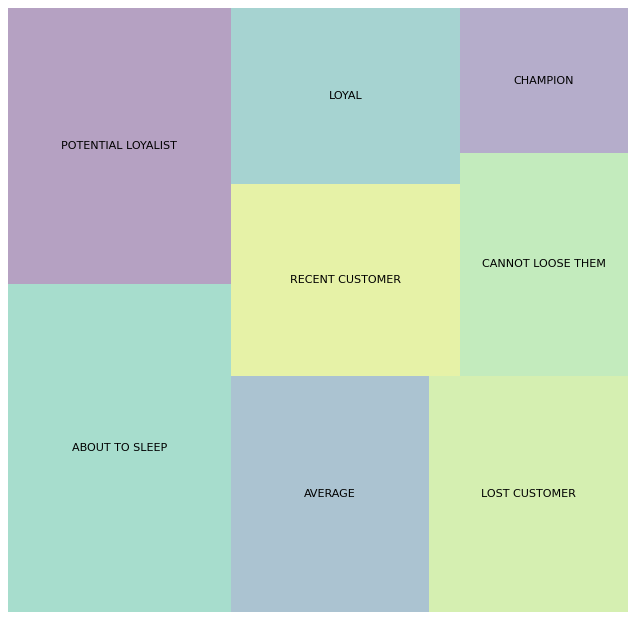

In [ ]:
plt.figure(figsize=(10, 10), dpi=80)
squarify.plot(sizes=data_rfm_final['rfm_score_name'].value_counts(), 
              label=list(data_rfm_final['rfm_score_name'].value_counts().index),  
              alpha=.4 )
plt.axis('off')
plt.show()